Status: ✅ Done

## Exercise 13

---

In this exercise session, we will first focus on theory behind `ensemble methods`. In the second part, we will return to the decision trees. More specifically, we will first experiment with how the input data impact the structure of the fitted decision regions. Later, we will train decision tree using `grid search` which allows us to test several combinations of `hyper-parameters`.

> Import

In [1]:
import random
import numpy as np
import pandas as pd
from scipy.stats import binom

from scripts.generate import syn1, syn2, syn3, spirals

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import preprocessing, tree
from sklearn.datasets import load_wine
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

> Ensemble methods recap

To recap ensemble methods, you can read my [note](https://ludekcizinsky.notion.site/Ensemble-methods-01a3876e838f4a19a791972d1481701f). After reading this or just before starting the exercise, you should have at least a bit of idea about the following:
- concept of ensemble methods (be able to explain it within 30s)
- be able to explain what is a weak classifier and why it makes sense to combine several of these into one model using the theoretical example with binoamial distribution. In addition, you should also relate this to the concept of `diversity`.
- be able to explain in 1 min the core differences between bagging and boosting (e.g. parallel vs sequential)
- be able to explain how bagging works and give concrete examples (e.g. random forest)
- be able to explain how to aggregate results from several models (e.g. hard/soft voting)
- be able to explain how boosting works and give again concrete examples (AdaBoost, GradientBoost)

We will practice most of these concepts below so do not worry if you do not feel that confident yet.

### Practicing theoretical concepts

---

> What are ensemble methods? And why diversity matters in ensemble model building?

Briefly, the core idea behind ensemble methods is to combine several classifiers together. In general, we have two ways we can combine them:
- train several classifiers `along each other` and then somehow aggregate their predictions (`bagging`)
- train several classifiers in a `sequential manner` such that each classifiers tries to improve the mistakes of the previous classifier in the chain

Most importantly, no matter which way we choose, we we must have `diversity` embedded into the ensemble model building. This can be done in two ways:
- `diverse models`: this can be as simple as changing hyper parameters, but also just choosing completely different model class
- `diverse training data`: we want our ensemble model to see as many different scenarios as possible, this is achieved via different training datasets

> Theoretical example

Imagine, that in we have $n$ classifiers and we know each of them makes a correct prediction with probability $p$. In addition, we make one more assumption which is that their predictions are `independent` and `identically distributed`. With all of this being said, bare in mind we are in `theoretical setting`. In practice, predictions of classifiers are correlated to a certain degree, i.e., they make the same type of mistakes. Finally, our final prediction is based on the `majority vote`. Therefore, if we have 5 classifiers, we need at least 3 classifiers to vote for the given class.

We are interested in the relation between number of samples $n$ and probability that our prediction will be correct. Using the example above, we need to compute probability that either 3 or 4 or all 5 classifiers are correct. This can be simply answered using `binomial distribution`. Recall, that binomial distribution tells you the probability of $k$ successes out of $n$ tries. In our case, success is defined as classifier being correct and the corresponding probability of that is $p$. Let's try to model this relationship for different $n$ and fixed $p = .51$, i.e., each of the classifier is a weak classifier and has a very slight chance of being correct:

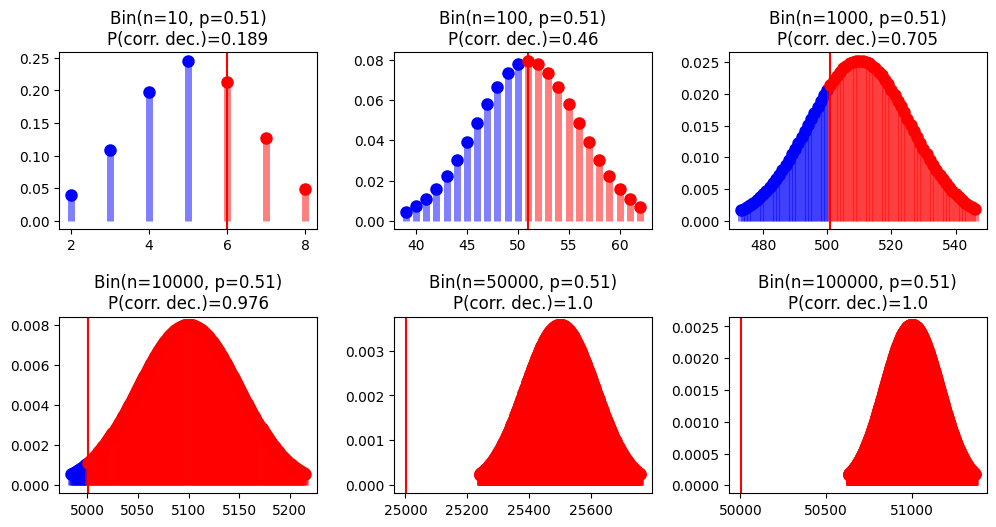

In [2]:
# Setup plot
fig, axs = plt.subplots(2, 3, figsize=(10, 5));
plt.tight_layout();
fig.subplots_adjust(wspace=0.3, hspace=.5);

# Setup parameters of binom distribution
Ns = [10, 100, 1000, 10000, 50000, 100000]
p = .51

i = 0
for rowax in axs:
    for ax in rowax:
        # Get number of classifiers
        n = Ns[i]

        # Generate x-values
        x = np.arange(binom.ppf(0.01, n, p), binom.ppf(0.99, n, p))

        # Generate y-values
        y = binom.pmf(x, n, p)

        # Define threshold for decision
        tr = n/2 + 1

        # Plot distribution
        # -- First half - does not count
        ax.plot(x[x < tr], y[x < tr], 'bo', ms=8, label='binom pmf 1');
        ax.vlines(x[x < tr], 0, binom.pmf(x[x < tr], n, p), colors='b', lw=5, alpha=0.5);

        # -- Second half - this what we care about
        ax.plot(x[x >= tr], y[x >= tr], 'ro', ms=8, label='binom pmf 2');
        ax.vlines(x[x >= tr], 0, binom.pmf(x[x >= tr], n, p), colors='red', lw=5, alpha=0.5);

        # Add the threshold
        ax.axvline(n/2 + 1, color='red');

        # Add labels
        total_prob = round(1 - binom.cdf(k=tr, n=n, p=p), 3)
        ax.set_title(f"Bin(n={n}, p={p})\nP(corr. dec.)={total_prob}")

        i += 1;

# Save figure
fig.savefig(f"figures/law_of_large_numbers/psuccess_{p}.png", bbox_inches='tight')

Try to change $p$ to be higher or lower and see what happens 😳. From the experiments, we can make the following conclusion:
> As $n$ grows, we have bigger and bigger probability that our final decision is correct. For very large $n$ we reach the maximum certainity. This holds under the assumption that $P(correct) > P(incorrect)$. As we increase $p$, we even need less $n$ to reach the maximum certainity state. With all of this being said, in reality we can not have the independency of predictions assumption and as such, maximum certainity is possible only in a theoretical setting. 😭 

> Soft vs hard voting

Let's consider the following scenario:
- We have a classification problem with two classes `Red` (0) and `Green` (1)
- we have traind 10 classifiers that produce estimates $p(\operatorname{Red} \mid X): 0.1,0.15,0.2,0.2,0.55,0.6,0.6,0.65,0.7,0.75$

What would be the final prediction if we use:
- hard voting?
- soft voting?

Let's solve this using simple code. First of all, we need to store our predictions into an array:

In [3]:
preds_red = np.array([.1, .15, .2, .2, .55, .6, .6, .65, .7, .75])
preds_green = np.array([1 - preds_red[i] for i in range(len(preds_red))])
preds = np.vstack((preds_red, preds_green)).T
preds

array([[0.1 , 0.9 ],
       [0.15, 0.85],
       [0.2 , 0.8 ],
       [0.2 , 0.8 ],
       [0.55, 0.45],
       [0.6 , 0.4 ],
       [0.6 , 0.4 ],
       [0.65, 0.35],
       [0.7 , 0.3 ],
       [0.75, 0.25]])

Using `hard vote classifier`, we would get:

In [4]:
# Get the total count of clfs and then count of those who voted for green class
n = preds.shape[0]
ngreen = np.argmax(preds, axis=1).sum()

# Decide using simple hard voting
tr = n/2
if ngreen > tr:
    print("Green")
elif ngreen < tr:
    print("Red")
else:
    print(f"Random choice: {random.choice(['Red', 'Green'])}")

Red


Now, using `soft vote classifier`:

In [5]:
# Compute averages
avgp_red = preds[:, 0].mean()
avgp_green = preds[:, 1].mean()

# Decide using the soft vote
if avgp_red > avgp_green:
    print("Red")
elif avgp_red < avgp_green:
    print("Green")
else:
    print(f"Random choice: {random.choice(['Red', 'Green'])}")

Green


As we can clearly see, we would get different decisions. Speaking from personal experience, it is better to use `soft classifier` as it is more robust metric that better accounts for uncertainity. But again, if you can, try both and whichever seems to work better for the given problem at hand, use.

> Dive into other aggregation functions

As we have seen in the previous subsection, voting classifiers calculate their final output from the combined outputs in different ways (hard- and soft-voting being the most common).

In this subsection, we will go over several `aggregating` techniques, try to understand them first and then evaluate their potential pros and cons. We can assume the following:
- we have an ensemble $H$ which has $m$ base classifiers, $h_m$ (with $m=1 \ldots M$ )
- given some input $x$, each classifier $h_m$ predicts class probabilities for each of $K$ output classes, such that $h_{m k}(x)$, and $\sum_{k=1}^K h_{m k}(x)=1$

Let's get into our analysis:

1. $\qquad \hat{y} = \arg \max_k  1/M \sum_{m=1}^M h_{mk} (x) $

- **Method:** Compute average probability for each of the respective classes and then select the class with highest avg probability. Yes, this should be familiar to you - this is `soft vote classifier`.

- **Effect of using it:** If the variance of probabilities for each class is large, then if for example two classifiers have a very different opinion, they cancel each other out. On the other hand, this could be also a problem since we can have classifiers which yield outlier values and then our average might be skewed.

2. $\qquad \hat{y} = \arg \max_k  \sum_{m=1}^M w_m h_{mk} (x) $ , (here $w$ is a weight, with  $w_m \ge 0 , \sum_{m=1}^M w_m = 1$)

- **Method:** Compute the weighted average for each of the respective classes and then select the class with highest avg probability.

- **Effect of using it:** In this case, we are given the additional freedom of giving to each classifier importance of the vote by multiplying its prediction by specific weight. I would not say that this method is neccesary better than the previous one. For example, I would use the previous one if I were to train the same classifier on different training sets. On the other hand, if I would have different classifiers then this method would be more useful.

3. $\qquad \hat{y} = \arg \max_k  \mathrm{median}_m h_{mk} (x) $ , ($\arg \max_k $ of $\mathrm{median}_m $ of $h_{mk} (x)$ )

- **Method:** Compute median probability for each of the respective classes and then select the class with highest median.

- **Effect of using it:** This method is more robust to outliers. I already discussed the trade off in the first method.

4. $\qquad \hat{y} = \arg \max_k  \mathrm{min_m} h_{mk} (x) $

- **Method:** Compute min probability for each of the respective classes and then select the class with highest minimum.

- **Effect of using it:** This seems to me as being very conservative, i.e., we first select the prediction for each class with lowest probability and then out of these probabilities selecting the biggest one. I would say that it depends on the classifiers which we have in our ensemble method. In other words, what is the reason for a classifier to assign the given $x$ with low probability? Perhaps, the low probability can be due to the classifiers in-ability to to capture complex patterns (bias) or the opposite problem that our classifier is overfitted. I would also say that you discard a lot of information that you obtain from other classifiers.

5. $\qquad \hat{y} = \arg \max_k  \mathrm{max_m} h_{mk} (x) $

- **Method:** Compute max probability for each of the respective classes and then select the class with highest maximum.

- **Effect of using it:** I would have the same arguments here as for the previous method, it is just inversed.

6. $\qquad \hat{y} = \arg \max_k  \prod_m h_{mk} (x) $

- **Method:** Compute the product of probabilities for each of the respective classes and then select the class with highest product.

- **Effect of using it:** I would say it is very similar to taking the mean of numbers in a sense that if you have two outliers (one small and one large), they cancel out each other in terms of the contribution to the decision. But you can also have outliers just one one side which will skew this metric. 

To summarize, which aggregation metric you choose depends on the problem at hand. As we have discussed above, each of them has its pros and cons which might be more or less suitable for your problem at hand. For instance, if we are ok with outliers in probabilities having a strong influence on our final prediction, we would go with for isntance soft voting, but perhaps we actually do not want thiis, and then using median might be more suitable.

> Bootstrapping

Recall, that bootstrapping is a way how to generate new dataset based on the existing dataset. More precisely, given some dataset $x$ of size $n$, we sample from it `with replacement` such that we obtain a new dataset $\hat{x}$ of size $m$. Note that $n$ and $m$ does not neccessary be the same, but within the scope of this subsection, we will assume they are. In addition, we will assume that each observarvation in the given dataset $x$ is equally likely to be picked, i.e., $P(x_i) = \frac{1}{n}$.

To make things more concrete, we have the following dataset $x$:

In [6]:
x = [i for i in range(5)]

Here is a function that will do the boostrap for us:

In [7]:
def bootstrap(x, m):
    xhat = []
    for i in range(m):
        xhat.append(random.choice(x))
    return xhat

So if we test it out several times:

In [8]:
for _ in range(3):
    print(bootstrap(x, 5))

[4, 3, 4, 0, 4]
[1, 1, 1, 1, 4]
[4, 0, 2, 3, 3]


Clearly, we can see that for instance there is a certain chance that some sample from $x$ does not appear in $\hat{x}$. Let's compute the probability of that happening. Since probability of picking any sample is $1/n$, we know that probability of not picking one particular sample is $1 - 1/n$. This applies for each position in $\hat{x}$ and since $n = m$, we can write that probability of not having particular sample at all in the bootstrap sample is $(1 - \frac{1}{n})^n$. For instance, in our case using the example:

In [9]:
n = 5
(1 - 1/n)**n

0.3276800000000001

Notice that this can be also computed through `binomial distribution`:

In [10]:
binom.pmf(0, n=5, p=1/5)

0.3276800000000002

where the probability of success, i.e., picking our sample is $1/5$, and we are interested in the case where we have no success, i.e., we do not pick our sample at all. This implies, that to find probability that our sample actually appears in the bootstrap dataset is $1 - (1 - \frac{1}{n})^n$. Again, using our example:

In [11]:
1 - (1 - 1/n)**n

0.6723199999999999

Therefore, for any of the samples in our dataset $x$, the probability that they will apear `at least once` in the bootstrapped dataset $\hat{x}$ is $P(x_i \in \hat{x}) = 1 - (1 - \frac{1}{n})^m$ where $m$ is the size of the bootstrapped dataset and $n$ is the size of dataset $x$ from which we sample. Let's now investigate the relationship between $n$ and $P(x_i \in \hat{x})$:

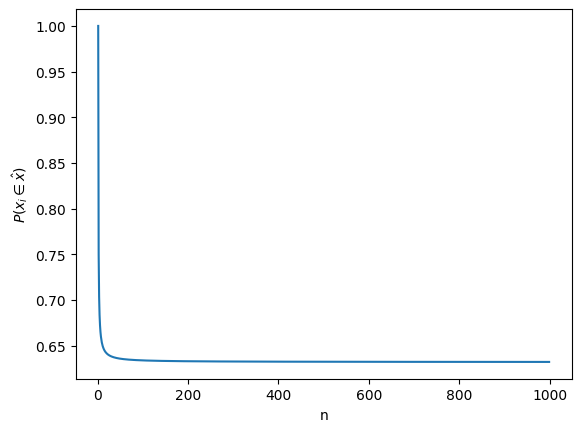

In [12]:
# Set different Ns
Ns = [i for i in range(1, 1000)]

# Create a function to compute the probability
prob = lambda n,m: 1 - (1 - 1/n)**m

# Compute the probs
probs = []
for n in Ns:
    probs.append(prob(n, n))

# Setup plot
fig, ax = plt.subplots()

# Plot the relationship
ax.plot(Ns, probs);
ax.set_xlabel("n");
ax.set_ylabel("$P(x_i \in \hat{x})$");

Interesting 😬 We can see that as $n$ goes to infinity, the $P(x_i \in \hat{x})$ converges at $.65$ In other words, this means that if we create for instance 1000 bootstrapped datasets, then in roughly 650 of them, given sample $x_i$ from the original dataset $x$ will be present. We can test this out as follows:

In [13]:
# Get bootstrapped data
bdata = []
for _ in range(1000):
    bdata.append(bootstrap(x, 5))

# Count how many times 0 appears there
count = 0
for d in bdata:
    if 0 in d:
        count += 1
print(count)

657


In practice, this is useful to know, since this means that we are guaranteed (for sufficiently large $n$) roughly one third of data that are not part of training and as such can be used for validation.

> Section summary

In this section, we have practiced the core theoretical concepts upon which `ensemble` methods are built. Namely, we have discussed:
-  what are ensemble methods and why diversity matters (as well as how we can introduce it to our model building process)
- we then discussed theoretical example which proves the idea behind ensembles, i.e., collection of weak learners can be stronger than a single strong model
- we then discussed different ways how one can aggregate results from classifiers, and concluded that which one to use always depends on the problem at hand (yes, in ML, everything depends on the problem at hand, main takeaway from this course 😅)
- finally, we explored a useful property of bootstrapping, i.e., that rougly one third of samples from original dataset $x$ do not end up in the bootstrapped dataset $\hat{x}$ assuming the sizes of both datasets are the same

### Decision trees and their dependency on training data

---

> Intro to the problem

In this section, we first explore the effects of different transformations on the resulting decision regions. Second, we also look how different training dataset impacts the overall tree structure. 

> Impact of centering, scaling and rotation on DT

Let's first consider the following transformations their potential impact, we would expect on DT:

- **Centering data.** Centering is essentialy shifting data up, down, left or right. This would not matter since DT draws lines perpendicular to feature axes. Therefore, the shape of boundary stays the same, but of course the decision thresholds might change for each feature.

- **Scaling data.** Same as above, it would not matter for DT, since it would still draw a straight line between any of the values of the particlar feature. It does not matter if the distances between values are scaled or not.

- **Rotation of data.** Here it would matter since for example if the data would be easily separable using a straight line going from one of the features and then we would rotate our data, our decision boundary would look way different. Since we might need more features to make the split. And as a result, the decision boundary would change.

Let's verify this using actual data and classifiers. First, we need to define rotation function:

In [14]:
def rotate(p, origin=(0, 0), degrees=0):
    """
    Disclaimer: found on the internet
    """
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

Let's now transorm the data accordingly:

In [15]:
# Generate the original data
Xo, y = spirals(100)

# Transformations to data
# * Center and scale
Xcs = preprocessing.StandardScaler(copy=True).fit_transform(Xo)
# * Rotate
Xr = rotate(Xcs, origin=(0, 0), degrees=45)

# Save all data into a single list, important for later use
X = [Xo, Xcs, Xr]

We will not train the models:

In [16]:
# Initiliaze model and train DTs
dt1 = DecisionTreeClassifier(max_depth=2, random_state=42).fit(Xo, y)
dt2 = DecisionTreeClassifier(max_depth=2, random_state=42).fit(Xcs, y)
dt3 = DecisionTreeClassifier(max_depth=2, random_state=42).fit(Xr, y)
clfs = [dt1, dt2, dt3]

Finally, we can visualize the result:

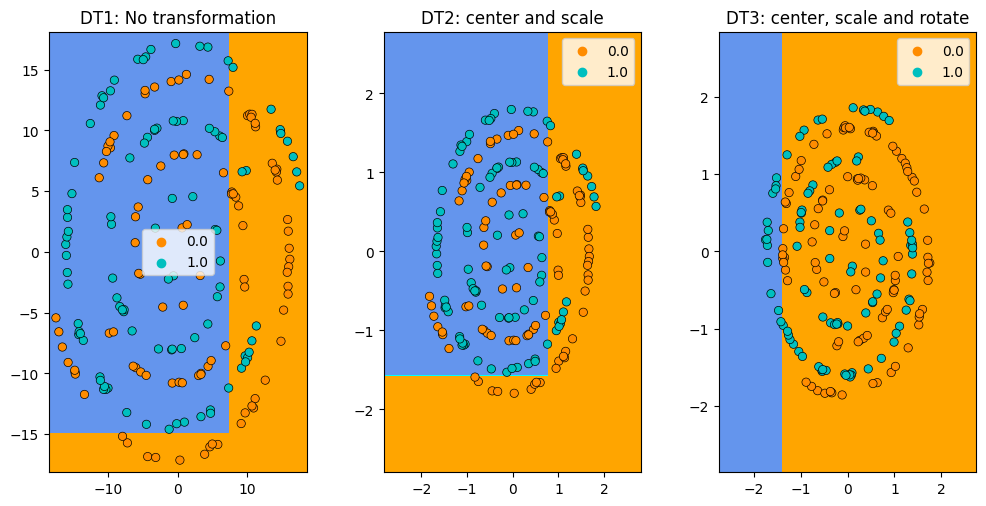

In [17]:
# Define plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5));
plt.tight_layout();
fig.subplots_adjust(wspace=0.3, hspace=.5);

# Define color schemes
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ['darkorange', 'c', 'darkblue']

# Define titles
titles = ["DT1: No transformation", "DT2: center and scale", "DT3: center, scale and rotate"]

# Mesh step
h = 0.02

for i, ax in enumerate(axs):

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[i][:, 0].min() - 1, X[i][:, 0].max() + 1
    y_min, y_max = X[i][:, 1].min() - 1, X[i][:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = clfs[i].predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[i][:, 0], y=X[i][:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    ax.set_title(titles[i]);

What we see exactly corresponds to what was written above. So is this a good or bad thing? Well, most of the algorithms that we have encountered so far have been parametric, i.e., they were combining features using estimated parameters. As such they were dependent on the scaling. This is not problem for DT clearly which in fact is actually a nice advantage. When it comes to transformations such as rotation, that is a different story. Compare to the other two transformations, rotation is non-linear. More importantly, however, if we think about what changes in terms of final decision, then nothing, we would still make the same prediction. On the other hand, if we wanted to hardcode the tree into some program, this might be a problem. Yes, I am serious, I have heard of company who wanted to hard code DT into their SQL DB 🤦🏻‍♂️.

> Impact of training data on DT

In this subsection, we will explore the impact of different training datasets on the decision regions of the DT. The best way of exploring is visualization, therefore, let's visualizate it:

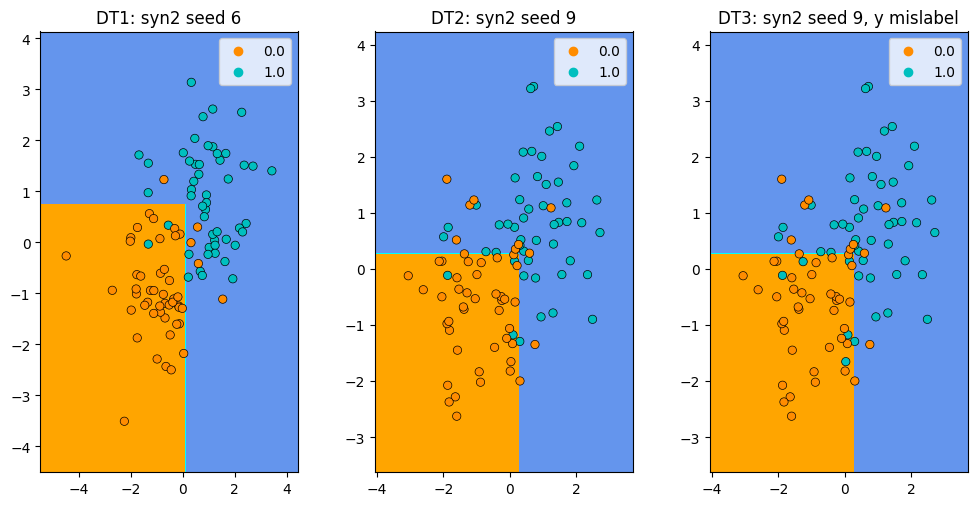

In [18]:
# Define plot
fig, axs = plt.subplots(1, 3, figsize=(10, 5));
plt.tight_layout();
fig.subplots_adjust(wspace=0.3, hspace=.5);

# Define seeds
seeds = [6, 9, 9]

# Define titles
titles = ["DT1: syn2 seed 6", "DT2: syn2 seed 9", "DT3: syn2 seed 9, y mislabel"]

# Show the subplots
for i, ax in enumerate(axs):

    # seed = 0 means random, seed > 0 means fixed
    np.random.seed(seeds[i])
        
    # Generate training data
    X, y = syn2(100)

    # Mislabel couple points (last subplot only)
    if i == 2:
        y[-1] = 0 if y[-1] == 1 else 1
        y[-5] = 0 if y[-5] == 1 else 1

    # Train a decision Tree
    clf = DecisionTreeClassifier(max_depth=2, random_state=seeds[i], min_samples_leaf=5).fit(X, y)

    # Create meshgrid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette=cmap_bold, alpha=1.0, edgecolor="black", ax=ax)
    ax.set_xlim(xx.min(), xx.max());
    ax.set_ylim(yy.min(), yy.max());
    ax.set_title(titles[i]);

We can see a clear change when it comes to having a completely new dataset. Here we only have 2 features, but if we had way more features, then the possible combination of boundaries increase exponentially. I also swapped couple labels to see the effect of this, and as we see, there does not seems to be any effect. Hoever, this also depends for which points we swap the labels. Again, this all confirms that you can not rely on these decision rules as if they were set in stone. In practice, you will have to retrain your model periodcially, so having the decision rules hard coded anywhere in the codebase is a super bad idea.

> Section summary

This section was focused on understanding DT from a perspective of a dataset that we feed it with. We have seen some pros and cons as well as things to be aware of. And I think the last point is most important.  Imagine your model does not work as expected, and you are trying to debug the problem. Knowing how input data impact the overal decision regions might help you solve it.

### Finding most optimal tree using GridSearch

---

> Intro to the problem

So far, we have mostly looked on theory behind decision trees, but barely touched the practical aspects of it. Therefore, in this section, we will focus on finding the most optimal tree using sklearn's `Gridsearch`.

For this we will use wine dataset:

In [19]:
# Load the data
X, y = load_wine(return_X_y=True)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

> Finding the most optimal parameters using GridSearch

Let's start with defining what hyper-parameters we want to test:

In [20]:
parameters = {'max_leaf_nodes': [i for i in range(2, 11)], 'min_samples_split': [i for i in range(2, 5)]}

Note that the keys in the dictinary must match the name of attributes of the given model. Feel free to choose your parameters. Now we fit the model, i.e., we find the combination of best hyper-parameters:

In [21]:
dt = DecisionTreeClassifier()
clf = GridSearchCV(dt, parameters).fit(X_train, y_train)

Let's examine the most important parameters of the best fitted model:

In [22]:
print(f"Depth: {clf.best_estimator_.get_depth()} | Number of leaves: {clf.best_estimator_.get_n_leaves()}")

Depth: 3 | Number of leaves: 6


We can also inspect the most important feature in terms how well it helps to reduce the impurity:

In [23]:
# Get feature names
fnames = load_wine().feature_names

# Get max value of feature importance
fimpmax =  np.max(clf.best_estimator_.feature_importances_)

# Get the feature name
fnames[np.where(clf.best_estimator_.feature_importances_ == fimpmax)[0][0]]

'flavanoids'

If we plot the tree, we can see that we use `flavanoids` in depth 1, i.e., `X[6] <= 1.4`. If we would compute the weighted gini impurity of its child nodes and compare it to the parents impurity (`.568`), we would find out that this is the biggest reduction in impurity. Of course, if the model would be using `flavanoids` also somewhere else in the tree, we would need to add also the reduction of impurity from here.

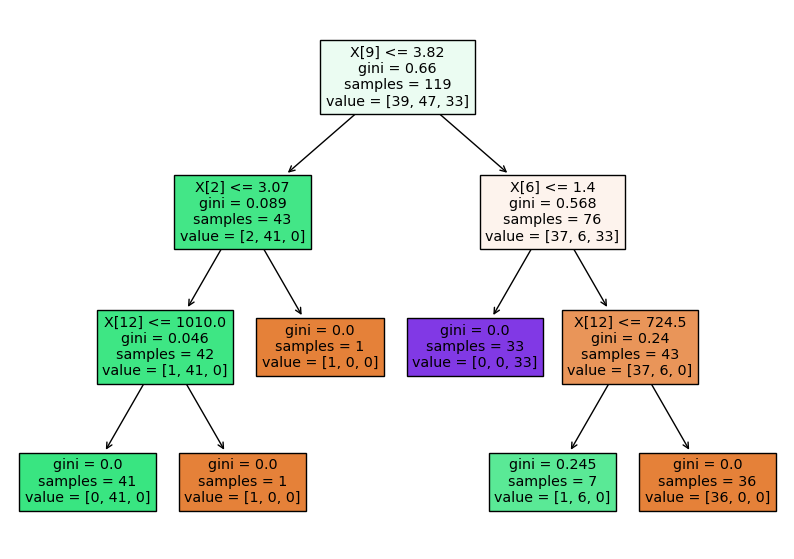

In [24]:
fig = plt.figure(figsize=(10,7))
_ = tree.plot_tree(clf.best_estimator_, filled=True)

Finally, let's see how our model does on test data:

In [25]:
clf.score(X_test, y_test)

0.9661016949152542

Pretty solid performance, I would assume that this will be due to the fact the the dataset is easily separable. We should have done this in the very beginning, but it is never too late to do some data exploration, let me first load the data into a dataframe

In [26]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


Next, let's do a pairplot with the 3 most important features according to the fitted model, i.e., features that have reduced the most of impurity:

In [27]:
# Create a list with feature idx and importance
feature_import = [[i, imp] for i, imp in enumerate(clf.best_estimator_.feature_importances_)]

# Sort
fisorted = sorted(feature_import, key=lambda x: x[1], reverse=True)

# Top 3 features
top3idx = [l[0] for l in fisorted[:3]]
top3idx

[6, 9, 12]

So, now we reduce our df to these columns along with the target class and make a `pairplot`:

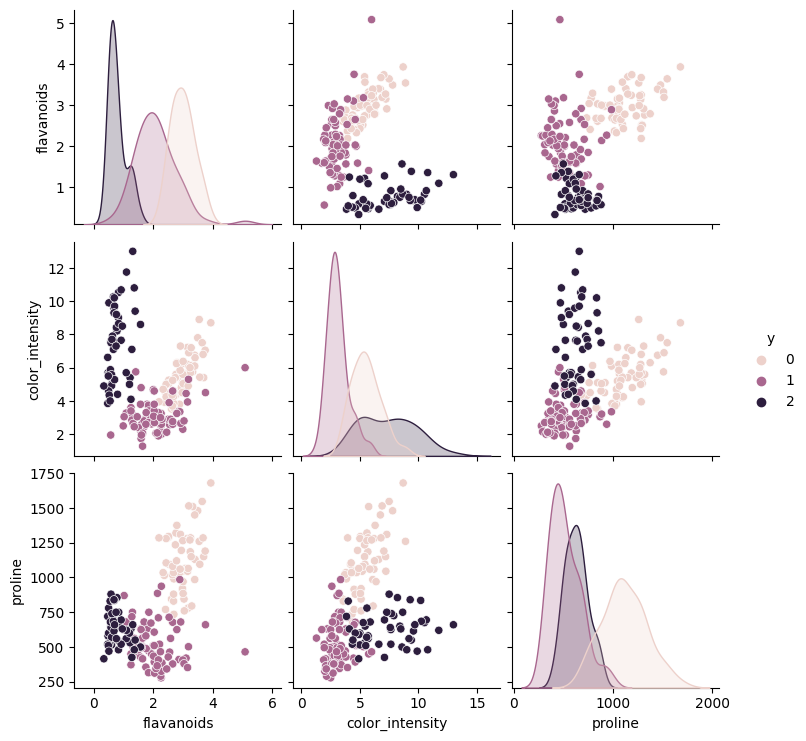

In [28]:
# Get the needed data
dfreduced = df.iloc[:, top3idx]
dfreduced['y'] = data.target

# Make a pairplot
sns.pairplot(data=dfreduced, hue='y');

This plot confirms my previous statement about relatively easy separability.

> Section summary

The goal of this section was to also give you the practical skill of training and evaluating decision tree. Therefore, if you are now asked in company to train `DT`, you will know exactly what to do 😎

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=57cb3e8b-763a-4858-97a0-0232b8facded' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>